In [1]:
# Import all required
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from types import SimpleNamespace
plt.style.use(["science", "ieee"])
from gic.model.oml import OceanModel
from gic.model.cables import Cable, TheoriticalSolver
from gic.model.utils import RecursiveNamespace, frexp102str
from gic.validation.simulate_synB_synT import SytheticCableAnalysis

from scipy.stats import pearsonr

In [ ]:
!python simulate.py

In [2]:
%matplotlib inline
# Synthetic B-field plot
Bt = pd.read_csv("tmp/out/001/Bt_syn.csv")
Bt.head()

,X,dTime
0,-0.000000e+00,0
1,-2.969900e-07,1
2,-1.157880e-06,2
3,-2.538300e-06,3
4,-4.394900e-06,4


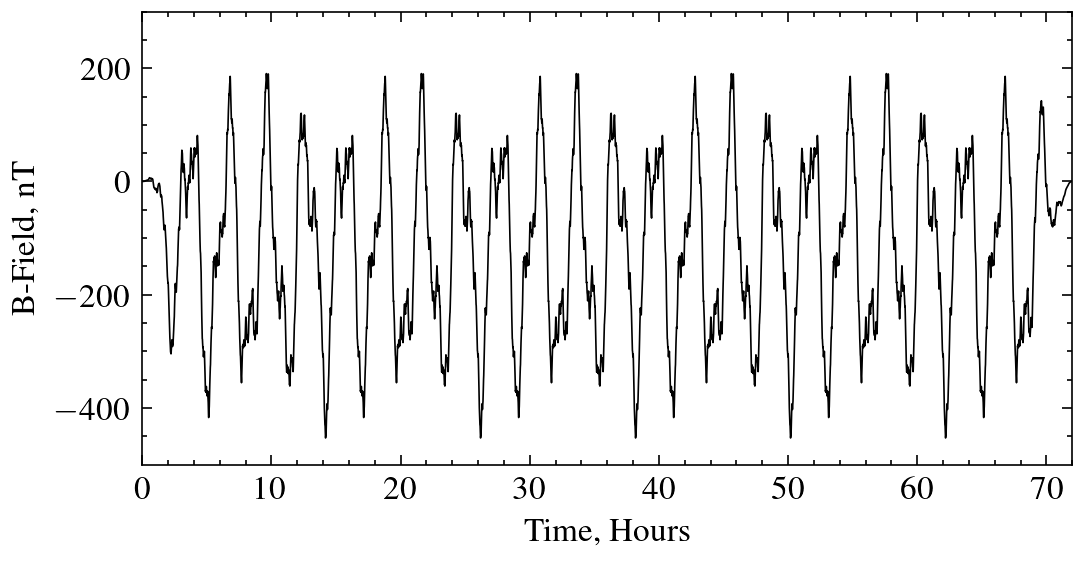

In [3]:
fig = plt.figure(dpi=240, figsize=(5,2.5))
ax = fig.add_subplot(111)
ax.plot(Bt.dTime / 3600.0, Bt.X, ls="-", lw=0.5)
ax.set_xlabel("Time, Hours")
ax.set_ylabel("B-Field, nT")
ax.set_xlim(0, 72)
_ = ax.set_ylim(-500, 300)